# Определяем тип звезды (кластеризация)
#### © Шулюгин Иван МГУ ВМК 325. ноябрь 2020

## Dataset

Размеченные данные отсюда - https://www.kaggle.com/deepu1109/star-dataset

Каждая строка описывает следующие признаки звезды: 
<li> абсолютная температура (в Кельвинах) </li>
<li> относительная яркость (относительно Солнца) </li>
<li> относительный радиус (относительно Солнца) </li>
<li> абсолютная велечина </li>
<li> тип звезды (это цель)</li>
<li> цвет звезды </li>
<li> спектральный класс </li>


Тип звезды (биект.отображение): [0, 1, 2, 3, 4, 5] <-> [Red Dwarf, Brown Dwarf, White Dwarf, Main Sequence , SuperGiants, HyperGiants]

In [1]:
# посмотрим на данные
import pandas as pd

In [2]:
file_name = '6_class.csv'

In [4]:
# будем использовать все кроме цвета и спектрального класса (это строки)
cols = list(pd.read_csv(file_name))
df = pd.read_csv(file_name, usecols=[i for i in cols if i not in ['Star color', 'Spectral Class']])
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
0,3068,0.002400,0.1700,16.12,0
1,3042,0.000500,0.1542,16.60,0
2,2600,0.000300,0.1020,18.70,0
3,2800,0.000200,0.1600,16.65,0
4,1939,0.000138,0.1030,20.06,0


Сделаем график, ориентируясь на температуру и абс.величину

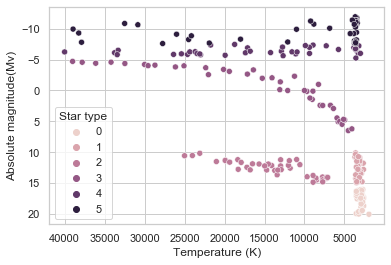

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
star_plot = sns.scatterplot(data=df, x="Temperature (K)", y="Absolute magnitude(Mv)", hue="Star type")
# !!! инвертируем оси, чтобы правильно сравнить с диаграммой ниже
star_plot.invert_yaxis()
star_plot.invert_xaxis()
plt.show()

Он должен напоминать диаграмму Герцшпрунга — Рассела (Hertzsprung–Russell diagram, HR diagram)

In [7]:
# запустите эту ячейку, чтобы посмотреть на HR-диаграмму, если она не прогрузилась ниже
from PIL import Image
from urllib.request import urlopen
url = "https://upload.wikimedia.org/wikipedia/commons/6/6b/HRDiagram.png"
image = Image.open(urlopen(url))
image.show()

hr_diagram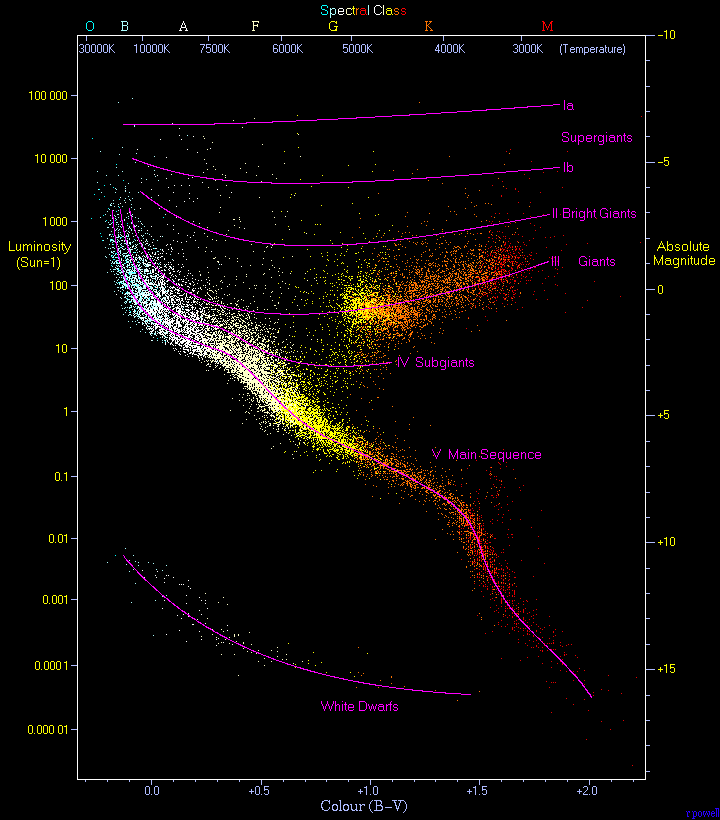

Заметно сходство

## Подготовим данные

Выделим отдельно признаки и ответы из таблицы

In [8]:
# названия колонок
cols = list(df)
print(cols)

['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Star type']


In [9]:
# берем все кроме типа звезды
dfx = pd.read_csv(file_name, usecols =[i for i in cols if i != 'Star type'])
# берем признаки как hr-диаграмме
df_hr = pd.read_csv(file_name, usecols =[i for i in cols if i in ['Temperature (K)', 'Absolute magnitude(Mv)']])
# берем ответы про тип звезды
dfy = pd.read_csv(file_name, usecols =['Star type'], squeeze=True)

In [10]:
# все преобразуем в списки
X = dfx.values.tolist()
X2 = df_hr.values.tolist() # здесь только два признака
Y = dfy.values.tolist()

print(len(X), len(X) == len(Y))

240 True


In [11]:
print(X[:5])
print(Y[:5])

[[3068.0, 0.0024, 0.17, 16.12], [3042.0, 0.0005, 0.1542, 16.6], [2600.0, 0.0003, 0.102, 18.7], [2800.0, 0.0002, 0.16, 16.65], [1939.0, 0.000138, 0.10300000000000001, 20.06]]
[0, 0, 0, 0, 0]


После всех действий выше мы имеем:
<li>Множества X, Y - выборка и ответы</li>
<li>Множество X2 - два признака (температура и величина)</li>

## Кластеризуем

Ориентируясь на HR-диаграмму возникает вопрос: а подойдет ли обычный алгоритм k-means, если для двух признаков данные не разбиваются на что-то сферическое? Проверим это.

Еще раз построим графики наших данных, но теперь для каждой пары признаков.

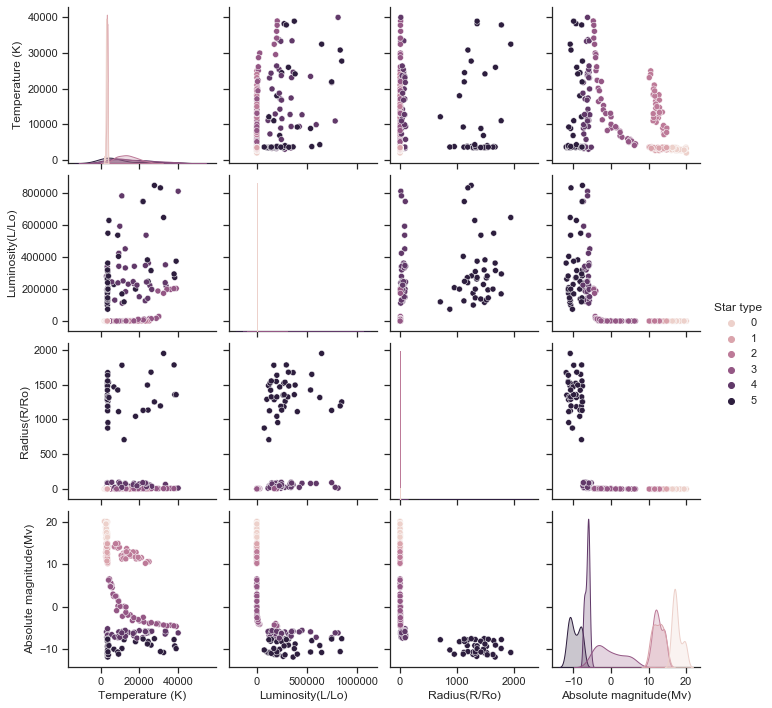

In [12]:
sns.set_theme(style="ticks")
sns.pairplot(df, hue='Star type')
plt.show()

Диаграмма у нас снизу слева. По ней как раз и хорошо видна структура данных.

## Используем k-means 
### вид: плоский, четкий

#### Алгоритм k-means:
1. Выбираем центроиды
2. Относим документы к центроидам
3. Смещаем центроиды
4. Идем на шаг 2, пока не достигним нужной точности при смещении центроидов

In [13]:
from sklearn.cluster import KMeans

#### Разбиваем для 4-х признаков

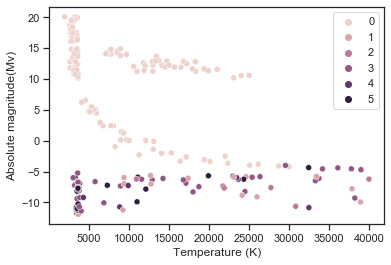

In [14]:
# кол-во кластеров = кол-ву типов звезд
Ypred = KMeans(n_clusters=6, random_state=1).fit_predict(X)

sns.scatterplot(data=df, x="Temperature (K)", y="Absolute magnitude(Mv)", hue=Ypred)
plt.show()

Как видим k-means плохо работает с такими кластерами.

#### Разбиваем для 2-х признаков

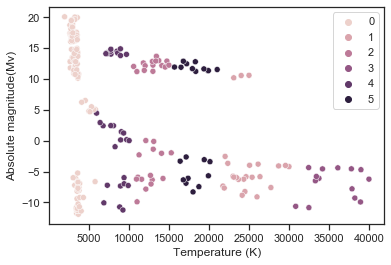

In [15]:
Ypred = KMeans(n_clusters=6, random_state=1).fit_predict(X2)

sns.scatterplot(data=df, x="Temperature (K)", y="Absolute magnitude(Mv)", hue=Ypred)
plt.show()

Очень грустно с точностью.

## Используем Agglomerative Clustering
### вид: иерархический - снизу вверх

Данный алгоритм ориентирован на протяженные кластеры.

#### Алгоритм AC (алгоритм Ланса-Уильямса):
1. Сначала все кластеры одноэлементные
2. Для каждой итерации находим ближайший кластер (следующие пункты)
3. Найти в прошлой итерации двух ближайших соседей
4. Слить их в один кластер и в пункт 2 (используется еще формула Ланса-Уильямса богатая частными случаями)

Подробнее тут: слайд 16 http://www.machinelearning.ru/wiki/images/archive/2/28/20150427184336%21Voron-ML-Clustering-slides.pdf

In [16]:
from sklearn.cluster import AgglomerativeClustering

#### Разбиваем для 4-х признаков

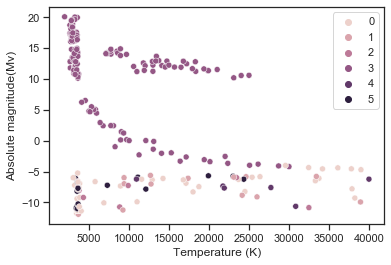

In [17]:
Ypred1 = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward').fit(X).labels_

sns.scatterplot(data=df, x="Temperature (K)", y="Absolute magnitude(Mv)", hue=Ypred1)
plt.show()

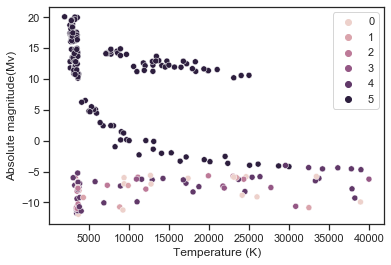

In [18]:
# меняем меру
Ypred2 = AgglomerativeClustering(n_clusters=6, affinity='l1', linkage='average').fit(X).labels_

sns.scatterplot(data=df, x="Temperature (K)", y="Absolute magnitude(Mv)", hue=Ypred2)
plt.show()

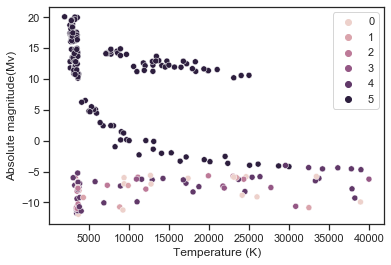

In [19]:
Ypred3 = AgglomerativeClustering(n_clusters=6, affinity='l2', linkage='average').fit(X).labels_

sns.scatterplot(data=df, x="Temperature (K)", y="Absolute magnitude(Mv)", hue=Ypred3)
plt.show()

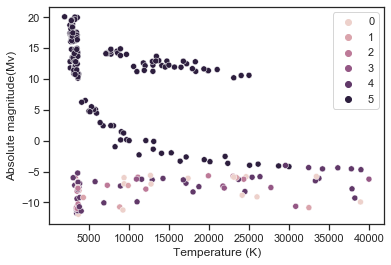

In [20]:
Ypred4 = AgglomerativeClustering(n_clusters=6, affinity='manhattan', linkage='average').fit(X).labels_

sns.scatterplot(data=df, x="Temperature (K)", y="Absolute magnitude(Mv)", hue=Ypred4)
plt.show()

#### Разбиваем для 2-х признаков

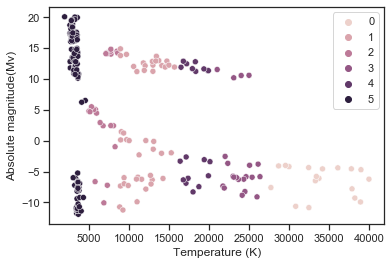

In [21]:
Ypred1 = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward').fit(X2).labels_

sns.scatterplot(data=df, x="Temperature (K)", y="Absolute magnitude(Mv)", hue=Ypred1)
plt.show()

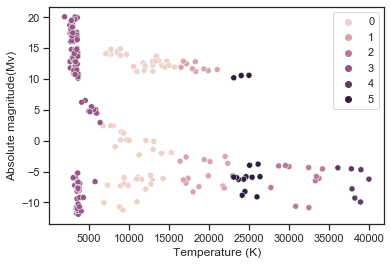

In [22]:
# меняем меру
Ypred2 = AgglomerativeClustering(n_clusters=6, affinity='l1', linkage='average').fit(X2).labels_

sns.scatterplot(data=df, x="Temperature (K)", y="Absolute magnitude(Mv)", hue=Ypred2)
plt.show()

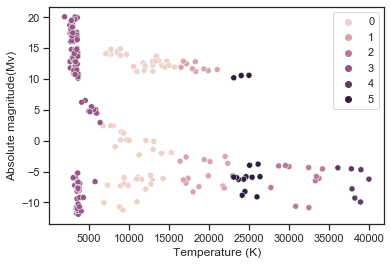

In [23]:
Ypred3 = AgglomerativeClustering(n_clusters=6, affinity='l2', linkage='average').fit(X2).labels_

sns.scatterplot(data=df, x="Temperature (K)", y="Absolute magnitude(Mv)", hue=Ypred3)
plt.show()

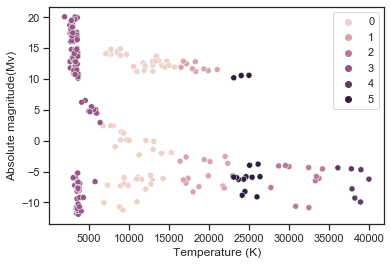

In [24]:
Ypred4 = AgglomerativeClustering(n_clusters=6, affinity='manhattan', linkage='average').fit(X2).labels_

sns.scatterplot(data=df, x="Temperature (K)", y="Absolute magnitude(Mv)", hue=Ypred4)
plt.show()

И тут далеко от желаемых кластеров, как это показано на hr-диаграмме

## Вывод о работе k-means и agglomerative clustering

На таком наборе данных они плохо справились с задачей. Нужные кластеры сложно выделить, в случае k-means из-за формы кластеров, а в случае с AC из-за недостатка документов, почему сложно сливать кластеры вместе на этапах работы алгоритма.

#### © Шулюгин Иван МГУ ВМК 325. ноябрь 2020